# BBVDATA Training

### Импортирование инструментов и инициализация данных

In [1]:
import math
import numpy
import pandas as pd 
import matplotlib.pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)
dataframe = pd.read_csv("preprocessed.csv").drop("Unnamed: 0", axis=1)

FileNotFoundError: File b'preprocessed.csv' does not exist

In [5]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [26]:
def create_dataset(d, look_back=1):
    df = pd.DataFrame()
    for i, col in enumerate(dataframe.columns):
        df[col] = d.T[i]
    d = df
    # normalize the dataset
    x_train, y_train = d.drop(["load", "amount"],axis=1).as_matrix(), d[["load", "amount"]].as_matrix()
    scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
    scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
    x_train = scaler_x.transform(x_train)
    y_train = scaler_y.transform(y_train)
    return numpy.array(x_train), numpy.array(y_train), scaler_x, scaler_y

In [85]:
feature_length = dataframe.shape[1]
dataset = dataframe
dataset = dataset.astype('float32').as_matrix()

/Users/dosya/Projects/lab_iis/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [87]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY, scaler_trainX, scaler_trainY = create_dataset(train, look_back)
testX, testY, scaler_testX, scaler_testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, feature_length-2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
h = model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

/Users/dosya/Projects/lab_iis/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Epoch 1/100
 - 1085s - loss: 0.0211 - acc: 0.8614
Epoch 2/100
 - 1061s - loss: 0.0193 - acc: 0.8749
Epoch 3/100
 - 1148s - loss: 0.0190 - acc: 0.8754
Epoch 4/100
 - 1161s - loss: 0.0189 - acc: 0.8759
Epoch 5/100
 - 1024s - loss: 0.0189 - acc: 0.8761
Epoch 6/100
 - 1276s - loss: 0.0188 - acc: 0.8764
Epoch 7/100
 - 2520s - loss: 0.0188 - acc: 0.8766
Epoch 8/100
 - 1043s - loss: 0.0188 - acc: 0.8766
Epoch 9/100
 - 1258s - loss: 0.0188 - acc: 0.8766
Epoch 10/100
 - 1405s - loss: 0.0188 - acc: 0.8765
Epoch 11/100


KeyboardInterrupt: 

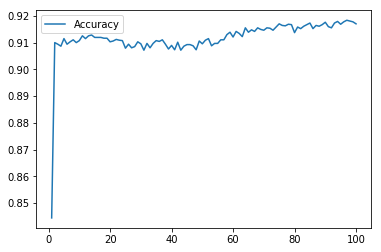

In [88]:
acc = h.history['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Accuracy')
plt.legend()
plt.show()

In [89]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [90]:
# invert predictions
trainPredict = scaler_trainY.inverse_transform(trainPredict)
trainY = scaler_trainY.inverse_transform(trainY)
testPredict = scaler_testY.inverse_transform(testPredict)
testY = scaler_testY.inverse_transform(testY)

Train Score: 18.03 RMSE
Test Score: 20.60 RMSE


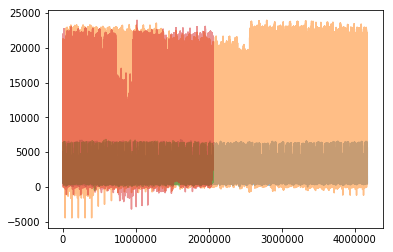

In [98]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(trainPredict)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot = testPredict
# plot baseline and predictions
plt.plot(scaler_trainY.inverse_transform(trainPredict), alpha=0.5)
plt.plot(scaler_testY.inverse_transform(testPredict), alpha=0.5)
plt.show()

In [99]:
import tensorflow as tf

In [100]:
correct = tf.equal(tf.argmax(testPredict, 1), tf.argmax(testY, 1))

In [101]:
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

In [102]:
testY[:5]

array([[ 20.,  13.],
       [ 10.,  59.],
       [ 20., 147.],
       [ 10.,  21.],
       [ 50.,  49.]], dtype=float32)

In [103]:
testPredict[:5]

array([[ 17.821918,  15.876712],
       [  6.059572,  79.5871  ],
       [ 29.672508, 145.4714  ],
       [ 13.581921,  64.140594],
       [ 32.42755 ,  50.132103]], dtype=float32)

In [97]:
model.save("model.h5")